**Ch37-38: Selenium自动化、网易云爬取MyGO歌词绘制词云**

Source: 
[数据分析实战 45 讲](https://time.geekbang.org/column/intro/100021701?tab=intro)

---

## Selenium自动化操作

* `driver.find_element(By.XPATH,'')`

* 在输入框中输入内容：`send_keys(content)`传入要输入的文本；
                     
* 清空输入框的内容：`clear()`；

* 点击按钮：`click()` ，元素得是个按钮或者链接；

* 提交表单：`submit()`。

* 在微博（或大多数动态加载的网页）中，通过Selenium查找元素时只能获取当前界面可见的部分，需要滚动：

```python
# 向下滚动500个像素
driver.execute_script('window.scrollBy(0,500)')
# 向上滚动500个像素
driver.execute_script('window.scrollBy(0,-500)')
```

## 词云

```python
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', # 设置背景颜色
    mask=backgroud_Image, # 设置背景图片
    font_path='./SimHei.ttf', # 设置字体，针对中文的情况需要设置中文字体，否则显示乱码
    max_words=100, # 设置最大的字数
    stopwords=STOPWORDS, # 设置停用词
  max_font_size=150, # 设置字体最大值
  width=2000, # 设置画布的宽度
  height=1200, # 设置画布的高度
    random_state=30 # 设置多少种随机状态，即多少种颜色
)
```
创建好WordCloud对象之后，就可以使用`wordcloud=generate(text)`方法生成词云，传入的参数text代表要分析的文本，最后使用`wordcloud.tofile('filename.jpg')`函数，将得到的词云图像直接保存为图片格式文件

In [ ]:
# 微博反爬机制太多了。。。。

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
# Use the correct path to my chromedriver
driver_path = "..."
driver = webdriver.Chrome(service=Service(driver_path))

def weibo_login(phone_num,pw):
    driver.get("https://passport.weibo.com/")
    driver.implicitly_wait(5)
    time.sleep(1)
    driver.find_element(By.XPATH,'//input[@aria-label="手机号或邮箱"]').send_keys(phone_num)
    driver.find_element(By.XPATH,'//input[@aria-label="密码"]').send_keys(pw)
    time.sleep(1)
    driver.find_element(By.XPATH,'//button[text()=" 登录 "]').click()   # inspect准了有没有空格哇！！就说xpath helper咋识别不出来两边没空格的
    # 遇到有空格的这种情况，也可以：//button[normalize-space(text())="登录"]
    time.sleep(1)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 生成词云啦啦啦啦啦啦


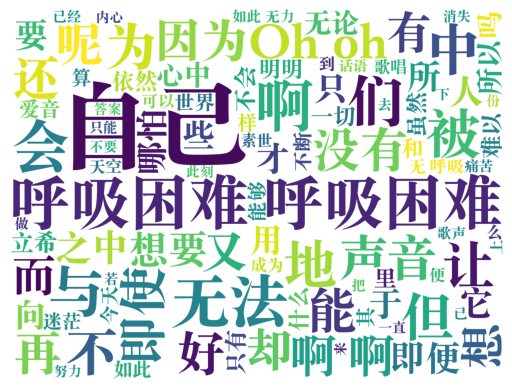

In [9]:
# 网易云是静态的，不用Selenium，好好好好好
import requests
from lxml import etree
import re
import sys
import json
import os
import matplotlib.pyplot as plt
import jieba
import numpy as np
from PIL import Image
from wordcloud import WordCloud

headers = {
    'Referer' :'http://music.163.com', 
    'Host' :'music.163.com', 
    'Accept' :'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8', 
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36' }
def get_songs(url):
    response = requests.get(url,headers=headers)
    html = etree.HTML(response.text)
    raw_song_ids = html.xpath("//*[@id='hotsong-list']//a/@href")
    song_ids = []
    #i = 0 # 只爬前200首的吧像我的歌单快一千了
    for raw_song_id in raw_song_ids:
        song_ids.append(raw_song_id[9:])  # eg. <a href="/song?id=1857630559"> 第九位开始才是能用到api地址的id
    return song_ids #这里会立即返回！！！！！导致for循环中只能执行一次！！！
def get_lyric(url):
    response = requests.get(url,headers=headers)  # 用的wyy的api，出来直接是json对象 
    if response.json().get('tlyric'): # json对象可以迭代
        lyric = response.json()['tlyric']['lyric']   # 去api里面自己找，可以筛选翻译后的歌词
        clean_lyric = re.sub(r'[\d:.[\]]','',lyric)  
        # \d（任意数字）:（普通冒号）.（普通点）[]（左右方括号，右边的需要转义，因为可以代表关掉此字符集）都会被匹配并替换(separately)
        return clean_lyric
    else:
        return ''
        print(response.json())
def remove_stop_words(file):
    stop_words = ['着','吧','就','都','这','也','那','将','你','我','了','的','是','在','作词', '作曲', '编曲', 'Arranger', '录音', '混音', '人声', 'Vocal', '弦乐', 'Keyboard', '键盘', '编辑', '助理', 'Assistants', 'Mixing', 'Editing', 'Recording', '音乐', '制作', 'Producer', '发行', 'produced', 'and', 'distributed']
    for stop_word in stop_words:
        file = file.replace(stop_word,'')
    return file


# 终于来生成词云啦
def create_word_cloud(file):
    print('生成词云啦啦啦啦啦啦')
    file = remove_stop_words(file)
    cut_text = " ".join(jieba.cut(file,cut_all=False,HMM=True))
    wc = WordCloud(font_path="/opt/anaconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/Songti.ttc",
                   max_words=100,
                   background_color='white',
                   width=2000,
                   height=1500,
                   random_state=20,
                   relative_scaling=0.4)
    wordcloud = wc.generate(cut_text)
    wordcloud.to_file("L38爬MyGO_词云.jpg")
    plt.imshow(wordcloud)
    plt.axis("off")   # 不要出现横纵坐标
    plt.show()



def main(url):
    song_ids = get_songs(url)
    all_lyrics = ''
    count=1
    for song_id in song_ids:
        lyric_url = f'http://music.163.com/api/song/lyric?os=pc&id={song_id}&lv=-1&kv=-1&tv=-1'
        print(count,end=" ")
        lyric = get_lyric(lyric_url)
        all_lyrics = f'{all_lyrics} {lyric}'
        count +=1
    create_word_cloud(all_lyrics)

main("https://music.163.com/artist?id=54743836")
        